In [1]:
# Importing libraries
import sys
import pathlib
import warnings
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
sns.set(font_scale = 1)


In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')
# Path to data 
data_dir = current_dir.parents[0].joinpath('dataBases','MS2-CY5_cyto543_560_woStim_short')


In [3]:
list_images, path_files, list_files_names, number_images = fa.ReadImages(directory=data_dir).read()

In [4]:
selected_image = list_images[0]
number_color_channels = selected_image.shape[3]

In [5]:
number_color_channels

4

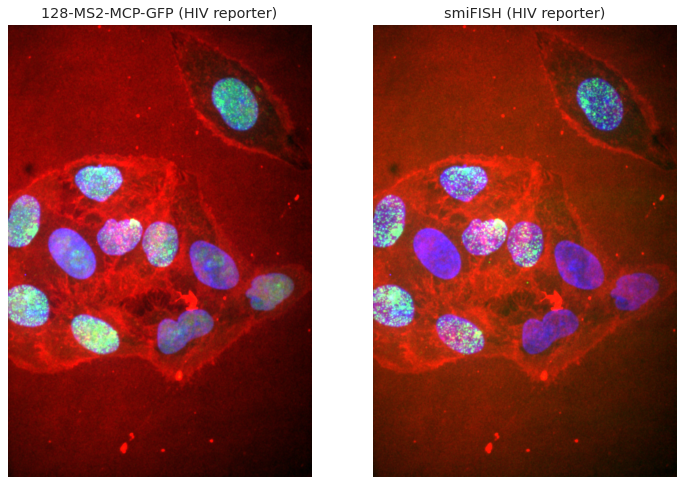

In [6]:
# Ploting merged image
img_filtered = fa.GaussianFilter(selected_image, sigma = 1).apply_filter()
max_img_filtered = np.max(img_filtered,axis=0)
img_filtered_int8 = fa.Utilities().convert_to_int8(max_img_filtered, rescale=True, min_percentile=0, max_percentile=99.5)

# Plot maximum projection
_, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 12))
axes[0].imshow( img_filtered_int8[:,:,[2,1,0]])
axes[0].grid(False)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('128-MS2-MCP-GFP (HIV reporter)' )

axes[1].imshow( img_filtered_int8[:,:,[2,3,0]])
axes[1].grid(False)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('smiFISH (HIV reporter)' )
plt.show()

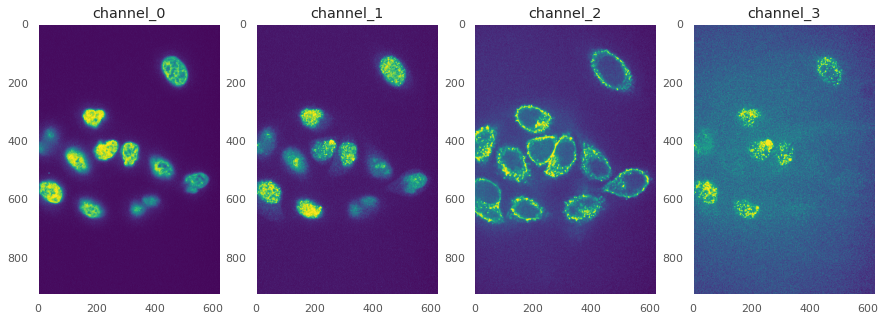

In [7]:
# Plotting each channel
selected_z_slice = 12
z_slice_selected_image = selected_image[selected_z_slice,:,:,:] #np.max(selected_image,axis=0)
z_slice_selected_image_removed_extreme = np.zeros_like(z_slice_selected_image)
min_percentile = 1
max_percentile = 99

for ch in range( z_slice_selected_image.shape[2]):
    z_slice_selected_image_removed_extreme[:,:,ch] = fa.RemoveExtrema(z_slice_selected_image[:,:,ch],min_percentile=min_percentile, max_percentile=max_percentile).remove_outliers() 
# Plot maximum projection
_, axes = plt.subplots(nrows = 1, ncols = number_color_channels, figsize = (15, 5))
for i in range(0, number_color_channels):
    axes[i].imshow(z_slice_selected_image_removed_extreme[:,:,i])
    axes[i].grid(False)
    #axes[i].set_xticks([])
    #axes[i].set_yticks([])
    axes[i].set_title('channel_'+str(i) )

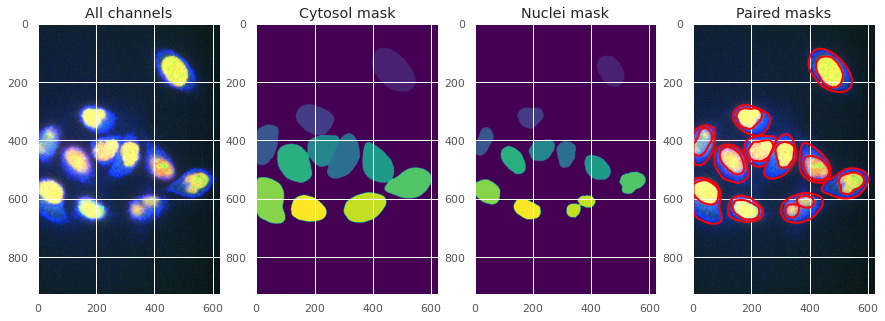

In [8]:
channels_with_cytosol = [2, 1]
channels_with_nucleus = [0, 1] 
channels_with_FISH = [1, 3]
diameter_cytosol = 160
diameter_nucleus = 80 
masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei = fa.CellSegmentation(image= z_slice_selected_image_removed_extreme,
                                                                                    channels_with_cytosol=channels_with_cytosol, 
                                                                                    channels_with_nucleus=channels_with_nucleus, 
                                                                                    diameter_cytosol=diameter_cytosol, 
                                                                                    diameter_nucleus=diameter_nucleus, 
                                                                                    show_plots = True,
                                                                                    optimization_segmentation_method = None,
                                                                                    image_name = 'temp' ).calculate_masks() 

In [10]:
threshold_intensity_0 = 500
threshold_intensity_1 = 500
dataframe_FISH, filtered_images, list_thresholds_spot_detection = fa.SpotDetection( z_slice_selected_image,
                                                    channels_with_FISH,
                                                    channels_with_cytosol,
                                                    channels_with_nucleus, 
                                                    minimum_spots_cluster = 2,
                                                    masks_complete_cells = masks_complete_cells, 
                                                    masks_nuclei = masks_nuclei, 
                                                    masks_cytosol_no_nuclei = masks_cytosol_no_nuclei, 
                                                    list_voxels = [ [500 , 160], [500 , 160] ],
                                                    list_psfs = [ [350 , 160] , [350 , 160] ], 
                                                    show_plots = False,
                                                    image_name = 'temp_detection',
                                                    threshold_for_spot_detection = [threshold_intensity_0, threshold_intensity_1]).get_dataframe()

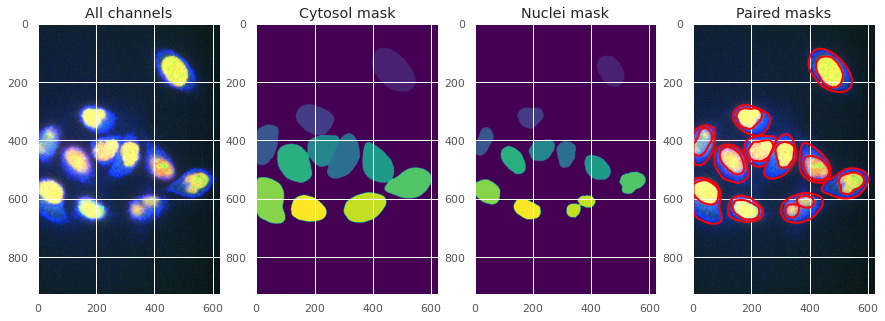

In [13]:
# Plotting cells with IDs
df_labels = dataframe_FISH.loc[ :, ['image_id','cell_id','nuc_loc_y','nuc_loc_x','cyto_loc_y','cyto_loc_x']].drop_duplicates()
fa.Plots().plotting_masks_and_original_image(image = z_slice_selected_image_removed_extreme, 
                                            masks_complete_cells = masks_complete_cells, 
                                            masks_nuclei = masks_nuclei, 
                                            channels_with_cytosol = channels_with_cytosol, 
                                            channels_with_nucleus = channels_with_nucleus,
                                            image_name = 'temp',
                                            show_plots = True,
                                            )

In [14]:
# Code to calculate the euclidian distance between the points in image 1 and image 2.
# ColocalizationDistance is intended to calculate the Euclidean 2nd norm distance between the spots detected in two FISH channels.
# Detecting colocalized spots as spots that are detected on both channels and are located within a MINIMAL_RADIUS_IN_PIXELS = 2. 
MINIMAL_RADIUS_IN_PIXELS = 2
df_spots_classification, df_coordinates_colocalized_spots, df_coordinates_0_only_spots, df_coordinates_1_only_spots = fa.ColocalizationDistance(df=dataframe_FISH,
                                                    threshold_intensity_0 = threshold_intensity_0, 
                                                    threshold_intensity_1 = threshold_intensity_1,
                                                    show_plots = False,
                                                    threshold_distance = MINIMAL_RADIUS_IN_PIXELS ).extract_spot_classification_from_df()

In [15]:
print(len(df_coordinates_0_only_spots))
print(len(df_coordinates_1_only_spots))
print(len(df_coordinates_colocalized_spots))


119
129
94


In [16]:
df_coordinates_colocalized_spots

,z,y,x,cell_id
0,0,118,452,0
1,0,124,452,0
2,0,129,467,0
3,0,133,454,0
4,0,147,491,0
...,...,...,...,...
89,0,651,182,10
90,0,650,204,10
91,0,651,213,10
92,0,655,207,10


In [17]:
# Pandas dataframe with the following columns: [time, ts_intensity_0, ts_intensity_1, ts_distance, image_id, cell_id, num_0_only, num_1_only, num_0_1, num_0, num_1, total]. 
    #num_0_only = num_type_0_only
    #num_1_only = num_type_1_only
    #num_0_1 = num_type_0_1
    #num_0 = num_type_0_only + num_type_0_1
    #num_1 = num_type_1_only + num_type_0_1
    #total = num_type_0_only + num_type_1_only + num_type_0_1
df_spots_classification

,time,ts_intensity_0,ts_intensity_1,ts_distance,image_id,cell_id,num_0_only,num_1_only,num_0_1,num_0,num_1,num_0_total,num_1_total,total
0,0,500,500,2,0,0,26,24,7,33,31,33,31,57
1,0,500,500,2,0,1,18,12,21,39,33,39,33,51
2,0,500,500,2,0,2,2,0,0,2,0,2,0,2
3,0,500,500,2,0,3,13,10,16,29,26,29,26,39
4,0,500,500,2,0,4,11,37,17,28,54,28,54,65
5,0,500,500,2,0,5,0,0,0,0,0,0,0,0
6,0,500,500,2,0,6,0,0,0,0,0,0,0,0
7,0,500,500,2,0,7,0,0,0,0,0,0,0,0
8,0,500,500,2,0,8,24,30,17,41,47,41,47,71
9,0,500,500,2,0,9,0,0,0,0,0,0,0,0


In [18]:
df_melted = pd.melt(df_spots_classification, id_vars = ['cell_id'], value_vars = ['num_0_only','num_1_only','num_0_1'])
#df_melted

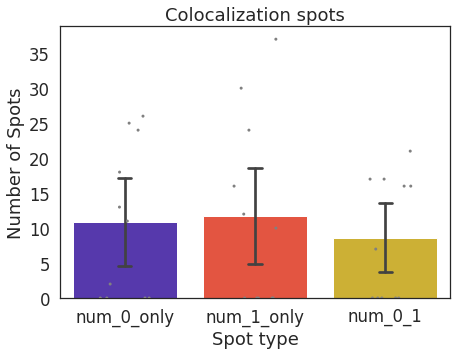

In [19]:
sns.set(font_scale = 1.5)
sns.set_style("white")
plt.figure(figsize=(7,5))
color_palete = 'CMRmap'
p_bar = sns.barplot( x = 'variable',
                        y = 'value',
                        data = df_melted,
                        capsize = 0.1,
                        #ci = "sd",
                        palette=color_palete)
p = sns.stripplot(data=df_melted, 
                x = 'variable',
                y = 'value',
                size=3, 
                color='0.5', 
                jitter=0.2)
# Show the plot
p_bar.set_xlabel('Spot type')
p_bar.set_ylabel('Number of Spots')
p_bar.set_title('Colocalization spots')
plt.show()

In [ ]:
#df_coordinates_colocalized_spots.head()

In [ ]:
#df_coordinates_0_only_spots

In [ ]:
#df_coordinates_1_only_spots

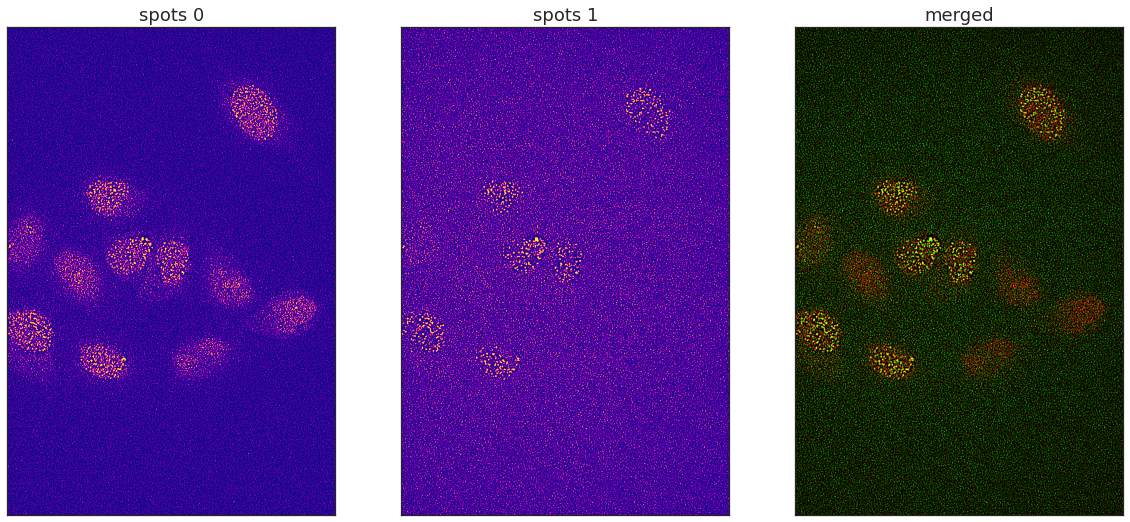

In [20]:
# plot image with detected spots
min_percentile = 1
max_percentile = 99
filtered_images_remove_extrema_first = fa.RemoveExtrema(filtered_images[0][0,:,:],min_percentile=min_percentile, max_percentile=max_percentile).remove_outliers() 
filtered_images_remove_extrema_second = fa.RemoveExtrema(filtered_images[1][0,:,:],min_percentile=min_percentile, max_percentile=max_percentile).remove_outliers() 
# merging both channels
merged_filtered_images = np.stack((filtered_images[0][0,:,:], filtered_images[1][0,:,:]), axis=-1)
merged_filtered_images_remove_extrema= fa.Utilities().convert_to_int8(merged_filtered_images, rescale=True, min_percentile=min_percentile, max_percentile=max_percentile)  

selected_cmap ='plasma'

# Plot filtered images with spots
_, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 12))
axes[0].imshow( filtered_images_remove_extrema_first,cmap=selected_cmap)
axes[0].grid(False)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('spots 0' )

axes[1].imshow( filtered_images_remove_extrema_second,cmap=selected_cmap)
axes[1].grid(False)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('spots 1' )

axes[2].imshow( merged_filtered_images_remove_extrema,cmap=selected_cmap)
axes[2].grid(False)
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title('merged' )

plt.show()
